In [1]:
import re
import os
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

Median radius ~ 400 nm
Ln(GSD) ~ 0.262
V ~ 24.5 um3/cc
DEHS particles (refractive index = 1.45 + 1e-5i at 532 nm)

These results are for different median size cases, namely, 200 nm, 400 nm, 600 nm and 800 nm. I included another CSV file that has the average number concentration with unit of #/cc. The GSD for these experiment are not exactly known but it is most likely between 1.05 to 1.1. Note that the unit for phase function is 1/Mm 1/str.

n addition to these narrow phase function data, I included another CSV file that has the phase function for a measurement conducted for broad size distribution with median size of 400 nm and GSD 1.4. This could already be included in the current ML model as its GSD is within the training range. Note that both phase function (P11) and polarized phase function (PPF) are include in the same csv file for the broad 400 nm data.
 
 

In [2]:
np.exp(0.262)

1.2995265424293818

# Open Data

In [3]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [1]:
directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_gaussian_AAE/'


In [5]:
#plot_dir = directory1 + 'version13/plots/measurement_data'
#if not os.path.exists(plot_dir):
#    os.makedirs(plot_dir)



In [6]:
model_dir5 = directory1 + 'version5/model' #(P_11 and P_12)
model_dir13 = directory1  + 'version13/model' #(P_11)
model_dir19 = directory1  + 'version19/model' #(P_12)


In [7]:
model_name = 'invertible_model'
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}
surr5 = InvertibleNetworkSurrogate.load(model_dir5, model_name, model_kwargs=kwargs)
surr13 = InvertibleNetworkSurrogate.load(model_dir13, model_name, model_kwargs=kwargs)
surr19 = InvertibleNetworkSurrogate.load(model_dir19, model_name, model_kwargs=kwargs)

#Load test data

In [8]:
test_datafile5 = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'
test_datafile13 ='/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_P11_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'
test_datafile19 = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_P12_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'

qoi_test5 = pd.read_hdf(test_datafile5,key = 'qoi')
dvar_test5 = pd.read_hdf(test_datafile5,key = 'dvar')
qoi_test13 = pd.read_hdf(test_datafile13,key = 'qoi')
dvar_test13 = pd.read_hdf(test_datafile13,key = 'dvar')
qoi_test19 = pd.read_hdf(test_datafile19,key = 'qoi')
dvar_test19 = pd.read_hdf(test_datafile19,key = 'dvar')


Real measurement data

In [9]:
data_dir = '/data/user/boiger_r/aerosol/aerosol_data/real_measurement_data_november_2021'
num_con = pd.read_csv(data_dir+"/number_concentration.csv")
phase_fun400 = pd.read_csv(data_dir+"/uNeph_PF_400nm_broad.csv")
phase_fun400_bin = pd.read_csv(data_dir+"/df_PF_Grasp_binned_P11P12_1wl.csv")

#"/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_november2021/df_PF_Grasp_binned_P11P12_1wl.csv"



phase_fun400_log = pd.read_csv(data_dir+"/df_PF_Grasp_lognorm_P11P12_1wl.csv")

#phase_funexp = pd.read_csv(data_dir+"/phase_function_experimental_data.csv")
#phase_funP11 = pd.read_csv(data_dir+"/phase_function_P11.csv")
#phase_funpolar = pd.read_csv(data_dir+'/polar_phase_function.csv')

In [10]:
data_real = pd.read_csv(data_dir+"/uNeph_GRASP_data.csv")

In [11]:
phase_fun400_bin

angle           P11       PPF
0     10.0  1.842700e-09  0.001620
1     11.0  1.782600e-09  0.002056
2     12.0  1.722900e-09  0.002535
3     13.0  1.661300e-09  0.003064
4     14.0  1.603500e-09  0.003624
..     ...           ...       ...
155  166.0  2.467100e-11 -0.197690
156  167.0  2.500000e-11 -0.180520
157  168.0  2.532100e-11 -0.163370
158  169.0  2.566800e-11 -0.146120
159  170.0  2.605400e-11 -0.128770

[160 rows x 3 columns]

In [12]:
data_real

angle    P11_uNeph  PPF_uNeph  P11_GRASP_lognorm  PPF_GRASP_lognorm  \
0      3.0  -856.143789  -1.480170                NaN                NaN   
1      4.0  -514.938575  -5.891817                NaN                NaN   
2      5.0  1766.402619  -0.051803                NaN                NaN   
3      6.0  1525.443884   0.002813                NaN                NaN   
4      7.0  1729.773492   0.016807                NaN                NaN   
..     ...          ...        ...                ...                ...   
169  173.0    32.343010  -0.011733                NaN                NaN   
170  174.0    33.801426   0.003998                NaN                NaN   
171  175.0    37.058601  -0.014041                NaN                NaN   
172  176.0    41.418983  -0.009016                NaN                NaN   
173  177.0    59.313611   0.015246                NaN                NaN   

     P11_GRASP_binned  PPF_GRASP_binned  
0                 NaN               NaN  
1                 NaN               NaN  
2                 NaN               NaN  
3                 NaN               NaN  
4                 NaN               NaN  
..                ...               ...  
169               NaN               NaN  
170               NaN               NaN  
171               NaN               NaN  
172               NaN               NaN  
173               NaN               NaN  

[174 rows x 7 columns]

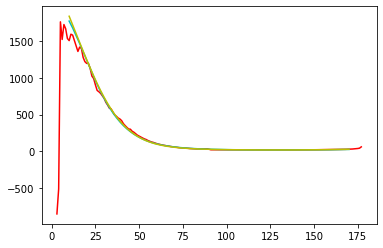

In [13]:
plt.plot(data_real['angle'],data_real['P11_uNeph'],'r')
plt.plot(data_real['angle'],data_real['P11_GRASP_lognorm'],'c')
plt.plot(data_real['angle'],data_real['P11_GRASP_binned'],'y')


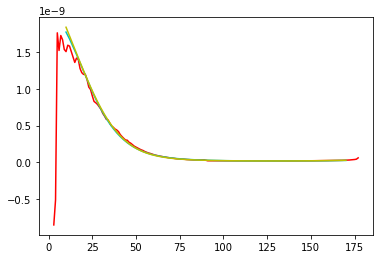

In [14]:
plt.plot(data_real['angle'],data_real['P11_uNeph']*1e-12,'r')
plt.plot(data_real['angle'],data_real['P11_GRASP_lognorm']*1e-12,'c')
plt.plot(data_real['angle'],data_real['P11_GRASP_binned']*1e-12,'y')

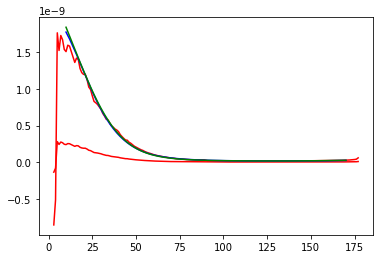

In [15]:
plt.plot(data_real['angle'],data_real['P11_uNeph']*1e-12,'r')
plt.plot(phase_fun400['angle'],phase_fun400['P11 [1/um]'],'r')
plt.plot(phase_fun400_log['angle'],phase_fun400_log['P11'],'b')
plt.plot(phase_fun400_bin['angle'],phase_fun400_bin['P11'],'g')

In [16]:
data_real['P11_uNeph']*1e-12

0     -8.561438e-10
1     -5.149386e-10
2      1.766403e-09
3      1.525444e-09
4      1.729773e-09
           ...     
169    3.234301e-11
170    3.380143e-11
171    3.705860e-11
172    4.141898e-11
173    5.931361e-11
Name: P11_uNeph, Length: 174, dtype: float64

In [17]:
np.log(data_real['P11_uNeph']*1e-12)

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0            NaN
1            NaN
2     -20.154321
3     -20.300980
4     -20.175275
         ...    
169   -24.154623
170   -24.110518
171   -24.018521
172   -23.907282
173   -23.548182
Name: P11_uNeph, Length: 174, dtype: float64

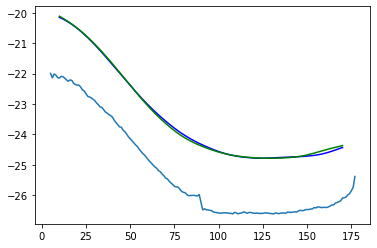

In [18]:
plt.plot(phase_fun400['angle'],np.log(phase_fun400['P11 [1/um]']))
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'b')
plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'g')

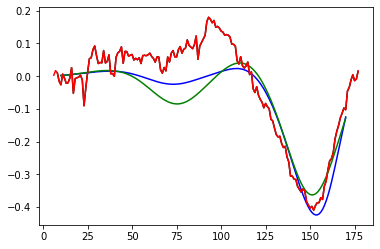

In [19]:
plt.plot(phase_fun400['angle'].iloc[5:],phase_fun400['-P12/P11'].iloc[5:],'k')
plt.plot(phase_fun400_log['angle'],phase_fun400_log['PPF'],'b')
plt.plot(phase_fun400_bin['angle'],phase_fun400_bin['PPF'],'g')
plt.plot(data_real['angle'].iloc[3:],data_real['PPF_uNeph'].iloc[3:],'r')

# transform real measurement data to right format

In [20]:
data400_P11 = pd.DataFrame(data=data_real['P11_uNeph']).transpose()
data400_P12 = pd.DataFrame(data=data_real['PPF_uNeph']).transpose()

In [21]:
phase400new_P11 = pd.DataFrame(data = phase_fun400['P11 [1/um]']).transpose()
phase400new_P12 = pd.DataFrame(data = phase_fun400['-P12/P11']).transpose()
phase400new_P11_log = pd.DataFrame(data = phase_fun400_log['P11']).transpose()
phase400new_P12_log = pd.DataFrame(data = phase_fun400_log['PPF']).transpose()
phase400new_P11_bin = pd.DataFrame(data = phase_fun400_bin['P11']).transpose()
phase400new_P12_bin = pd.DataFrame(data = phase_fun400_bin['PPF']).transpose()

In [22]:
listindex_data1 = []
listindex_data2 = []
for i in range(len(data_real['angle'])):
    listindex_data1.append("P11_0.532_"+str(int(data_real['angle'].iloc[i])))
    listindex_data2.append("P12_0.532_"+str(int(data_real['angle'].iloc[i])))

In [23]:
listindex = []
for i in range(len(phase_fun400['angle'])):
    listindex.append("P11_0.532_"+str(int(phase_fun400['angle'].iloc[i])))
listindex2 = []
for i in range(len(phase_fun400['angle'])):
    listindex2.append("P12_0.532_"+str(int(phase_fun400['angle'].iloc[i])))

    
listindex1_log = []
for i in range(len(phase_fun400_log['angle'])):
    listindex1_log.append("P11_0.532_"+str(int(phase_fun400_log['angle'].iloc[i])))
listindex2_log = []
for i in range(len(phase_fun400_log['angle'])):
    listindex2_log.append("P12_0.532_"+str(int(phase_fun400_log['angle'].iloc[i])))    

listindex1_bin = []
for i in range(len(phase_fun400_bin['angle'])):
    listindex1_bin.append("P11_0.532_"+str(int(phase_fun400_bin['angle'].iloc[i])))
listindex2_bin = []
for i in range(len(phase_fun400_bin['angle'])):
    listindex2_bin.append("P12_0.532_"+str(int(phase_fun400_bin['angle'].iloc[i])))        

In [24]:
dicts_data_1 = {}
j = 0
for i in data400_P11.columns:
    dicts_data_1[i]=listindex_data1[j]
    j=j+1
dicts_data_2 = {}
j = 0
for i in data400_P12.columns:
    dicts_data_2[i]=listindex_data2[j]
    j=j+1

In [25]:
dicts = {}
j = 0
for i in phase400new_P11.columns:
        dicts[i] = listindex[j]
        j=j+1

dicts2 = {}
j = 0
for i in phase400new_P12.columns:
        dicts2[i] = listindex2[j]
        j=j+1       

dicts1_log = {}
j = 0
for i in phase400new_P11_log.columns:
        dicts1_log[i] = listindex1_log[j]
        j=j+1

dicts2_log = {}
j = 0
for i in phase400new_P12_log.columns:
        dicts2_log[i] = listindex2_log[j]
        j=j+1        
        
dicts1_bin = {}
j = 0
for i in phase400new_P11_bin.columns:
        dicts1_bin[i] = listindex1_bin[j]
        j=j+1

dicts2_bin = {}
j = 0
for i in phase400new_P12_bin.columns:
        dicts2_bin[i] = listindex2_bin[j]
        j=j+1           

In [26]:
newdata400_P11 = data400_P11.rename(dicts_data_1, axis =1)
newdata400_P12 = data400_P12.rename(dicts_data_2, axis =1)

In [27]:
newpdP11 = phase400new_P11.rename(dicts,axis = 1)
newpdP12 = phase400new_P12.rename(dicts2,axis = 1)
newpdP11_log = phase400new_P11_log.rename(dicts1_log,axis = 1)
newpdP12_log = phase400new_P12_log.rename(dicts2_log,axis = 1)
newpdP11_bin = phase400new_P11_bin.rename(dicts1_bin,axis = 1)
newpdP12_bin = phase400new_P12_bin.rename(dicts2_bin,axis = 1)

In [28]:
newdata400_P12

P12_0.532_3  P12_0.532_4  P12_0.532_5  P12_0.532_6  P12_0.532_7  \
PPF_uNeph     -1.48017    -5.891817    -0.051803     0.002813     0.016807   

           P12_0.532_8  P12_0.532_9  P12_0.532_10  P12_0.532_11  P12_0.532_12  \
PPF_uNeph     0.009994    -0.015661     -0.026478      0.006169     -0.006233   

           ...  P12_0.532_168  P12_0.532_169  P12_0.532_170  P12_0.532_171  \
PPF_uNeph  ...      -0.113302      -0.097383      -0.102803      -0.045366   

           P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  \
PPF_uNeph      -0.034427      -0.011733       0.003998      -0.014041   

           P12_0.532_176  P12_0.532_177  
PPF_uNeph      -0.009016       0.015246  

[1 rows x 174 columns]

In [29]:
newdata400_P11 = newdata400_P11.rename({"P11_uNeph":'0'},axis=0)
newdata400_P12 = newdata400_P12.rename({"PPF_uNeph":'0'},axis=0)


In [30]:
newpdP12 = newpdP12.rename({'-P12/P11':'0'},axis = 0)
newpdP11 = newpdP11.rename({'P11 [1/um]':'0'},axis = 0)

newpdP12_log = newpdP12_log.rename({'PPF':'0'},axis = 0)
newpdP11_log = newpdP11_log.rename({'P11':'0'},axis = 0)
newpdP12_bin = newpdP12_bin.rename({'PPF':'0'},axis = 0)
newpdP11_bin = newpdP11_bin.rename({'P11':'0'},axis = 0)

In [31]:
def extrapolate(x,x2,x1,y2,y1):
    return y1+(x-x1)/(x2-x1)*(y2-y1)


In [32]:
newpdP11_log['P11_0.532_171']=extrapolate(171,170,169,newpdP11_log['P11_0.532_170'],newpdP11_log['P11_0.532_169'])
newpdP11_log['P11_0.532_172']=extrapolate(172,171,170,newpdP11_log['P11_0.532_171'],newpdP11_log['P11_0.532_169'])
newpdP11_log['P11_0.532_173']=extrapolate(173,172,171,newpdP11_log['P11_0.532_172'],newpdP11_log['P11_0.532_169'])
newpdP11_log['P11_0.532_174']=extrapolate(174,173,172,newpdP11_log['P11_0.532_173'],newpdP11_log['P11_0.532_169'])
newpdP11_log['P11_0.532_175']=extrapolate(175,174,173,newpdP11_log['P11_0.532_174'],newpdP11_log['P11_0.532_169'])


In [33]:
newpdP12_log['P11_0.532_171']=extrapolate(171,170,169,newpdP11_log['P11_0.532_170'],newpdP11_log['P11_0.532_169'])
newpdP12_log['P11_0.532_172']=extrapolate(172,171,170,newpdP11_log['P11_0.532_171'],newpdP11_log['P11_0.532_169'])
newpdP12_log['P11_0.532_173']=extrapolate(173,172,171,newpdP11_log['P11_0.532_172'],newpdP11_log['P11_0.532_169'])
newpdP12_log['P11_0.532_174']=extrapolate(174,173,172,newpdP11_log['P11_0.532_173'],newpdP11_log['P11_0.532_169'])
newpdP12_log['P11_0.532_175']=extrapolate(175,174,173,newpdP11_log['P11_0.532_174'],newpdP11_log['P11_0.532_169'])


In [34]:
newpdP11_log['P11_0.532_9']=extrapolate(9,10,11,newpdP11_log['P11_0.532_10'],newpdP11_log['P11_0.532_11'])
newpdP11_log['P11_0.532_8']=extrapolate(8,9,10,newpdP11_log['P11_0.532_9'],newpdP11_log['P11_0.532_10'])
newpdP11_log['P11_0.532_7']=extrapolate(7,8,9,newpdP11_log['P11_0.532_8'],newpdP11_log['P11_0.532_9'])
newpdP11_log['P11_0.532_6']=extrapolate(6,7,8,newpdP11_log['P11_0.532_7'],newpdP11_log['P11_0.532_8'])
newpdP11_log['P11_0.532_5']=extrapolate(5,6,7,newpdP11_log['P11_0.532_6'],newpdP11_log['P11_0.532_7'])


In [35]:
newpdP12_log['P12_0.532_9']=extrapolate(9,10,11,newpdP12_log['P12_0.532_10'],newpdP12_log['P12_0.532_11'])
newpdP12_log['P12_0.532_8']=extrapolate(8,9,10,newpdP12_log['P12_0.532_9'],newpdP12_log['P12_0.532_10'])
newpdP12_log['P12_0.532_7']=extrapolate(7,8,9,newpdP12_log['P12_0.532_8'],newpdP12_log['P12_0.532_9'])
newpdP12_log['P12_0.532_6']=extrapolate(6,7,8,newpdP12_log['P12_0.532_7'],newpdP12_log['P12_0.532_8'])
newpdP12_log['P12_0.532_5']=extrapolate(5,6,7,newpdP12_log['P12_0.532_6'],newpdP12_log['P12_0.532_7'])


In [36]:
P11_column_names = list(filter(re.compile(".*P11").match, qoi_test5.columns))
P12_column_names = list(filter(re.compile(".*P12").match, qoi_test5.columns))
P11_column_names

['P11_0.532_5',
 'P11_0.532_6',
 'P11_0.532_7',
 'P11_0.532_8',
 'P11_0.532_9',
 'P11_0.532_10',
 'P11_0.532_11',
 'P11_0.532_12',
 'P11_0.532_13',
 'P11_0.532_14',
 'P11_0.532_15',
 'P11_0.532_16',
 'P11_0.532_17',
 'P11_0.532_18',
 'P11_0.532_19',
 'P11_0.532_20',
 'P11_0.532_21',
 'P11_0.532_22',
 'P11_0.532_23',
 'P11_0.532_24',
 'P11_0.532_25',
 'P11_0.532_26',
 'P11_0.532_27',
 'P11_0.532_28',
 'P11_0.532_29',
 'P11_0.532_30',
 'P11_0.532_31',
 'P11_0.532_32',
 'P11_0.532_33',
 'P11_0.532_34',
 'P11_0.532_35',
 'P11_0.532_36',
 'P11_0.532_37',
 'P11_0.532_38',
 'P11_0.532_39',
 'P11_0.532_40',
 'P11_0.532_41',
 'P11_0.532_42',
 'P11_0.532_43',
 'P11_0.532_44',
 'P11_0.532_45',
 'P11_0.532_46',
 'P11_0.532_47',
 'P11_0.532_48',
 'P11_0.532_49',
 'P11_0.532_50',
 'P11_0.532_51',
 'P11_0.532_52',
 'P11_0.532_53',
 'P11_0.532_54',
 'P11_0.532_55',
 'P11_0.532_56',
 'P11_0.532_57',
 'P11_0.532_58',
 'P11_0.532_59',
 'P11_0.532_60',
 'P11_0.532_61',
 'P11_0.532_62',
 'P11_0.532_63',
 '

In [37]:
newpdP11_log1=newpdP11_log.reindex(columns = P11_column_names)
newpdP12_log1=newpdP12_log.reindex(columns = P12_column_names)


In [38]:
newpdP11_log1

P11_0.532_5   P11_0.532_6   P11_0.532_7   P11_0.532_8   P11_0.532_9  \
0  2.003000e-09  1.957700e-09  1.912400e-09  1.867100e-09  1.821800e-09   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0  1.776500e-09  1.731200e-09  1.683000e-09  1.630600e-09  1.579900e-09  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0   2.258400e-11   2.305300e-11   2.353300e-11   2.401900e-11   2.450300e-11   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0   2.498700e-11   2.595500e-11   2.789100e-11   3.176300e-11   3.950700e-11  

[1 rows x 160 columns]

In [39]:
#newpdP11['P11_0.532_173'] = newpdP11['P11_0.532_176']
#newpdP11['P11_0.532_174'] = newpdP11['P11_0.532_177']
#newpdP11['P11_0.532_175'] = newpdP11['P11_0.532_177']

In [40]:
#newpdP12['P12_0.532_173'] = newpdP12['P12_0.532_176']
#newpdP12['P12_0.532_174'] = newpdP12['P12_0.532_177']
#newpdP12['P12_0.532_175'] = newpdP12['P12_0.532_177']

In [41]:
newpdP11_s = newpdP11.drop(['P11_0.532_3'],axis =1)

In [42]:
newpdP11_s = newpdP11.drop(['P11_0.532_3','P11_0.532_4','P11_0.532_176','P11_0.532_177'],axis = 1)

In [43]:
newpdP11_s = newpdP11_s.drop(['P11_0.532_85','P11_0.532_86','P11_0.532_87','P11_0.532_88','P11_0.532_89','P11_0.532_91','P11_0.532_92','P11_0.532_93','P11_0.532_94','P11_0.532_95'],axis =1)


In [44]:
newpdP11_s = np.log(newpdP11_s)

In [45]:
newpdP11_s

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -21.992198   -22.138857   -22.013152   -22.046841   -22.130284   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -22.148891    -22.092726    -22.100672    -22.149605     -22.20426  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0     -26.262103     -26.238466     -26.217909     -26.181366     -26.094216   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0     -26.085832     -26.062446       -25.9925     -25.948395     -25.856398  

[1 rows x 160 columns]

In [46]:
newpdP12_s = newpdP12.drop(['P12_0.532_3','P12_0.532_4','P12_0.532_176','P12_0.532_177'],axis = 1)

In [47]:
newpdP12_s =newpdP12_s.drop(['P12_0.532_85','P12_0.532_86','P12_0.532_87','P12_0.532_88','P12_0.532_89','P12_0.532_91','P12_0.532_92','P12_0.532_93','P12_0.532_94','P12_0.532_95'],axis =1)


In [48]:
newpdP12_s

P12_0.532_5  P12_0.532_6  P12_0.532_7  P12_0.532_8  P12_0.532_9  \
0    -0.051803     0.002813     0.016807     0.009994    -0.015661   

   P12_0.532_10  P12_0.532_11  P12_0.532_12  P12_0.532_13  P12_0.532_14  ...  \
0     -0.026478      0.006169     -0.006233     -0.021966     -0.020498  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.150502      -0.127397      -0.113302      -0.097383      -0.102803   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.045366      -0.034427      -0.011733       0.003998      -0.014041  

[1 rows x 160 columns]

In [49]:
phase400new5 = pd.concat([newpdP11_s,newpdP12_s],axis =1)
phase400new13 = newpdP11_s
phase400new19 = newpdP12_s

In [50]:
newdata400_P12

P12_0.532_3  P12_0.532_4  P12_0.532_5  P12_0.532_6  P12_0.532_7  \
0     -1.48017    -5.891817    -0.051803     0.002813     0.016807   

   P12_0.532_8  P12_0.532_9  P12_0.532_10  P12_0.532_11  P12_0.532_12  ...  \
0     0.009994    -0.015661     -0.026478      0.006169     -0.006233  ...   

   P12_0.532_168  P12_0.532_169  P12_0.532_170  P12_0.532_171  P12_0.532_172  \
0      -0.113302      -0.097383      -0.102803      -0.045366      -0.034427   

   P12_0.532_173  P12_0.532_174  P12_0.532_175  P12_0.532_176  P12_0.532_177  
0      -0.011733       0.003998      -0.014041      -0.009016       0.015246  

[1 rows x 174 columns]

In [51]:
newdata400_P12['P12_0.532_3']

0   -1.48017
Name: P12_0.532_3, dtype: float64

In [52]:
newdata400_P11_s = newdata400_P11.drop(['P11_0.532_3','P11_0.532_4','P11_0.532_85','P11_0.532_86','P11_0.532_87','P11_0.532_88','P11_0.532_89','P11_0.532_91','P11_0.532_92','P11_0.532_93','P11_0.532_94','P11_0.532_95','P11_0.532_176','P11_0.532_177'],axis =1)
newdata400_P11_s

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0  1766.402619  1525.443884  1729.773492  1672.471319  1538.578323   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0   1510.215538   1597.463275   1584.820141   1509.136553   1428.869096  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0      24.699807      25.290593      25.815868      26.776699      29.214997   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0      29.460967      30.158069       32.34301      33.801426      37.058601  

[1 rows x 160 columns]

In [53]:
newdata400_P12_s = newdata400_P12.drop(['P12_0.532_3','P12_0.532_4','P12_0.532_85','P12_0.532_86','P12_0.532_87','P12_0.532_88','P12_0.532_89','P12_0.532_91','P12_0.532_92','P12_0.532_93','P12_0.532_94','P12_0.532_95','P12_0.532_176','P12_0.532_177'],axis =1)
newdata400_P12_s

P12_0.532_5  P12_0.532_6  P12_0.532_7  P12_0.532_8  P12_0.532_9  \
0    -0.051803     0.002813     0.016807     0.009994    -0.015661   

   P12_0.532_10  P12_0.532_11  P12_0.532_12  P12_0.532_13  P12_0.532_14  ...  \
0     -0.026478      0.006169     -0.006233     -0.021966     -0.020498  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.150502      -0.127397      -0.113302      -0.097383      -0.102803   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.045366      -0.034427      -0.011733       0.003998      -0.014041  

[1 rows x 160 columns]

In [54]:
newdata400_P11_s

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0  1766.402619  1525.443884  1729.773492  1672.471319  1538.578323   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0   1510.215538   1597.463275   1584.820141   1509.136553   1428.869096  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0      24.699807      25.290593      25.815868      26.776699      29.214997   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0      29.460967      30.158069       32.34301      33.801426      37.058601  

[1 rows x 160 columns]

In [55]:
newdata400_P11_s = np.log(newdata400_P11_s*1e-12)

In [56]:
newdata400_P11_s

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -20.154321    -20.30098   -20.175275   -20.208963   -20.292407   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -20.311013    -20.254849    -20.262795    -20.311728    -20.366383  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0     -24.424226     -24.400589     -24.380032     -24.343489     -24.256339   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0     -24.247955     -24.224569     -24.154623     -24.110518     -24.018521  

[1 rows x 160 columns]

In [57]:
newdata400_c = pd.concat([newdata400_P11_s,newdata400_P12_s],axis =1) 
newdata400_c

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -20.154321    -20.30098   -20.175275   -20.208963   -20.292407   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -20.311013    -20.254849    -20.262795    -20.311728    -20.366383  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.150502      -0.127397      -0.113302      -0.097383      -0.102803   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.045366      -0.034427      -0.011733       0.003998      -0.014041  

[1 rows x 320 columns]

# Transform data from GRASP to the right format

# Reformatted Real Measurement data

In [58]:
P11_column_names = list(filter(re.compile(".*P11").match, qoi_test5.columns))
P12_column_names = list(filter(re.compile(".*P12").match, qoi_test5.columns))
P11_column_names

['P11_0.532_5',
 'P11_0.532_6',
 'P11_0.532_7',
 'P11_0.532_8',
 'P11_0.532_9',
 'P11_0.532_10',
 'P11_0.532_11',
 'P11_0.532_12',
 'P11_0.532_13',
 'P11_0.532_14',
 'P11_0.532_15',
 'P11_0.532_16',
 'P11_0.532_17',
 'P11_0.532_18',
 'P11_0.532_19',
 'P11_0.532_20',
 'P11_0.532_21',
 'P11_0.532_22',
 'P11_0.532_23',
 'P11_0.532_24',
 'P11_0.532_25',
 'P11_0.532_26',
 'P11_0.532_27',
 'P11_0.532_28',
 'P11_0.532_29',
 'P11_0.532_30',
 'P11_0.532_31',
 'P11_0.532_32',
 'P11_0.532_33',
 'P11_0.532_34',
 'P11_0.532_35',
 'P11_0.532_36',
 'P11_0.532_37',
 'P11_0.532_38',
 'P11_0.532_39',
 'P11_0.532_40',
 'P11_0.532_41',
 'P11_0.532_42',
 'P11_0.532_43',
 'P11_0.532_44',
 'P11_0.532_45',
 'P11_0.532_46',
 'P11_0.532_47',
 'P11_0.532_48',
 'P11_0.532_49',
 'P11_0.532_50',
 'P11_0.532_51',
 'P11_0.532_52',
 'P11_0.532_53',
 'P11_0.532_54',
 'P11_0.532_55',
 'P11_0.532_56',
 'P11_0.532_57',
 'P11_0.532_58',
 'P11_0.532_59',
 'P11_0.532_60',
 'P11_0.532_61',
 'P11_0.532_62',
 'P11_0.532_63',
 '

# Predict dvar from measurement data

In [59]:
#dvar_pred_iv5 = surr5.sample_n_tries(phase400new5.values, batch_size=128, n_tries=32)
#dvar_pred_iv13 = surr13.sample_n_tries(phase400new13.values, batch_size=128, n_tries=32)
#dvar_pred_iv19 = surr19.sample_n_tries(phase400new19.values, batch_size=128, n_tries=32)


In [60]:
newdata400_c

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -20.154321    -20.30098   -20.175275   -20.208963   -20.292407   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -20.311013    -20.254849    -20.262795    -20.311728    -20.366383  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.150502      -0.127397      -0.113302      -0.097383      -0.102803   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.045366      -0.034427      -0.011733       0.003998      -0.014041  

[1 rows x 320 columns]

In [61]:
newdata400_c.values

array([[-2.01543208e+01, -2.03009804e+01, -2.01752754e+01,
        -2.02089635e+01, -2.02924070e+01, -2.03110135e+01,
        -2.02548489e+01, -2.02627949e+01, -2.03117282e+01,
        -2.03663825e+01, -2.04141317e+01, -2.03711546e+01,
        -2.03847161e+01, -2.04767589e+01, -2.05222429e+01,
        -2.05417399e+01, -2.05401496e+01, -2.06010740e+01,
        -2.06976624e+01, -2.07310006e+01, -2.08211869e+01,
        -2.09098505e+01, -2.09320523e+01, -2.09610086e+01,
        -2.10041172e+01, -2.10497967e+01, -2.11298075e+01,
        -2.11858874e+01, -2.12573616e+01, -2.12727116e+01,
        -2.13502069e+01, -2.14258026e+01, -2.14637005e+01,
        -2.15148181e+01, -2.15446290e+01, -2.15978706e+01,
        -2.16992467e+01, -2.17736367e+01, -2.18459043e+01,
        -2.19160961e+01, -2.19268772e+01, -2.20219694e+01,
        -2.20742847e+01, -2.21518077e+01, -2.22409902e+01,
        -2.23028681e+01, -2.23696786e+01, -2.24353278e+01,
        -2.25046569e+01, -2.25561774e+01, -2.26449227e+0

In [91]:
## 4mal laufen lassen gibt bestes Resultat!!!
dvar_pred_iv5 = surr5.sample_n_tries(newdata400_c.values, batch_size=128, n_tries=32)
dvar_pred_iv13 = surr13.sample_n_tries(newdata400_P11_s.values, batch_size=128, n_tries=32)
dvar_pred_iv19 = surr19.sample_n_tries(newdata400_P12_s.values, batch_size=128, n_tries=32)


In [92]:
dvar_pred_iv13 = pd.DataFrame(data=dvar_pred_iv13, columns=dvar_test5.columns)
dvar_pred_iv13

V_tot  R_median       GSD         n     k_532
0  25.639913  0.397122  1.422206  1.360472  0.014296

In [93]:
dvar_pred_iv5

array([[3.35262687e+04, 1.02823973e+01, 1.51838670e+00, 2.93562039e+00,
        1.00902092e+00]])

In [94]:
dvar_pred_iv5 = pd.DataFrame(data=dvar_pred_iv5, columns=dvar_test5.columns)
dvar_pred_iv5

V_tot   R_median       GSD        n     k_532
0  33526.26866  10.282397  1.518387  2.93562  1.009021

In [95]:
dvar_pred_iv19 = pd.DataFrame(data=dvar_pred_iv19, columns=dvar_test19.columns)
dvar_pred_iv19

V_tot   R_median       GSD        n     k_532
0  41575.03873  12.592411  1.572265  2.10813 -0.628092

# Compare to true values

In [96]:
Parameters1 = pd.DataFrame([])
n = 1.45
k = 1e-5
m = n+1j*k
sigma = np.exp(0.262) #1.4
rmean = 0.25 #0.4
Vtot = 20.106
wavelength = 532
#Parameters1['RealRefractiveIndex']=[n]
#Parameters1['ImaginaryRefractiveIndex']= k
#Parameters1['Sigma']=sigma
#Parameters1['MeanRadius']=rmean
#Parameters1['VolumeConcentration']=Vtot

# GRASP P11 retrieval
Parameters2 = pd.DataFrame([])
n2 = 1.44738
k2 = 0.29496E-03
Vtot2 = 20.15
rmean2 = 0.26567
sigma2 = 1.28

# GRASP P11, PPF retrieval
Parameters3 = pd.DataFrame([])
n3 = 1.44749
k3 = 0.17341E-03
Vtot3 = 20.13
rmean3 = 0.265
sigma3 = 1.27

In [97]:
Parameters1['V_tot']=[Vtot]
Parameters1['R_median']=rmean
Parameters1['GSD']=sigma
Parameters1['n']=n
Parameters1['k_532']=k

Parameters2['V_tot']=[Vtot2]
Parameters2['R_median']=rmean2
Parameters2['GSD']=sigma2
Parameters2['n']=n2
Parameters2['k_532']=k2

Parameters3['V_tot']=[Vtot3]
Parameters3['R_median']=rmean3
Parameters3['GSD']=sigma3
Parameters3['n']=n3
Parameters3['k_532']=k3

#Parameters3['V_tot']=[27.705646]
#Parameters3['R_median']=0.392594 
#Parameters3['GSD']=1.422337
#Parameters3['n']=n
#Parameters3['k_532']=0.012761



In [98]:
Parameters3

V_tot  R_median   GSD        n     k_532
0  20.13     0.265  1.27  1.44749  0.000173

In [99]:
Parameters3

V_tot  R_median   GSD        n     k_532
0  20.13     0.265  1.27  1.44749  0.000173

In [103]:
np.exp(0.262)

1.2995265424293818

In [104]:
Parameters1

V_tot  R_median       GSD     n    k_532
0  20.106      0.25  1.299527  1.45  0.00001

In [105]:
dvar_pred_iv5

V_tot   R_median       GSD        n     k_532
0  33526.26866  10.282397  1.518387  2.93562  1.009021

In [106]:
dvar_pred_iv13

V_tot  R_median       GSD         n     k_532
0  25.639913  0.397122  1.422206  1.360472  0.014296

In [107]:
dvar_pred_iv19

V_tot   R_median       GSD        n     k_532
0  41575.03873  12.592411  1.572265  2.10813 -0.628092

In [108]:
# Parameter k_532 is not included in the original data set. 

In [109]:
def pdf(Vtot, x, mu, sigma):
    return Vtot/(np.sqrt(2*np.pi)*np.log(sigma))*np.exp(-(np.log(x)-np.log(mu))**2.0/(2*(np.log(sigma))**2.0))

$sizedistr(x)=\frac{ V_{tot}}{( \log(GSD) \sqrt{2 \pi})}\exp(\frac{-\log(x)-\log(R_{mean})^2} {(2 \log(GSD)^2)})$

In [110]:
Parameters3

V_tot  R_median   GSD        n     k_532
0  20.13     0.265  1.27  1.44749  0.000173

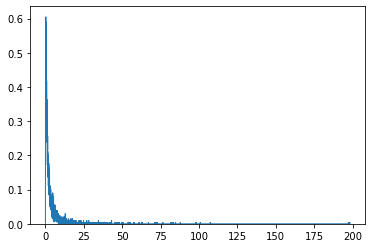

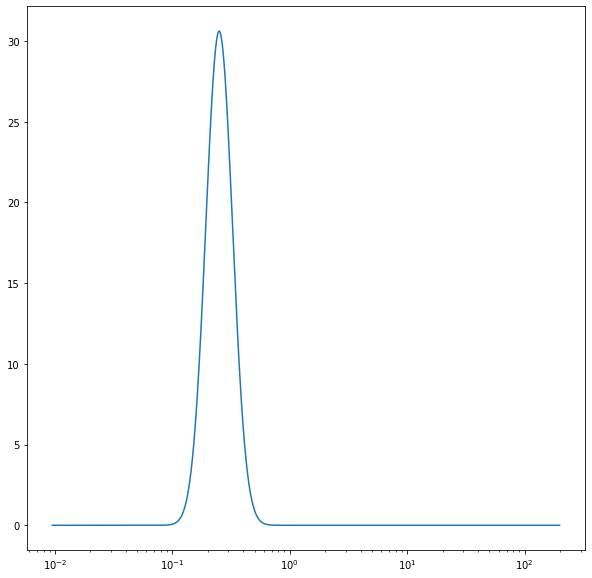

In [111]:

mu1 = Parameters1['R_median'][0]
sigma1 = Parameters1['GSD'][0]
Vtot1 = Parameters1['V_tot'][0]
s1 = np.random.lognormal(mu1, sigma1, 10000)   
count1, bins1, ignored1 = plt.hist(s1, 10000, density=True, align='mid',histtype = 'step')
x1 = np.linspace(min(bins1), max(bins1), 100000)
#pdf1 = Vtot1*(np.exp(-(np.log(x1) - np.log(mu1))**2 / (2 * sigma1**2)) / ( sigma1 * np.sqrt(2 * np.pi)))
pdf1 = pdf(Vtot1,x1,mu1,sigma1)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x1,pdf1)
ax.set_xscale('log')

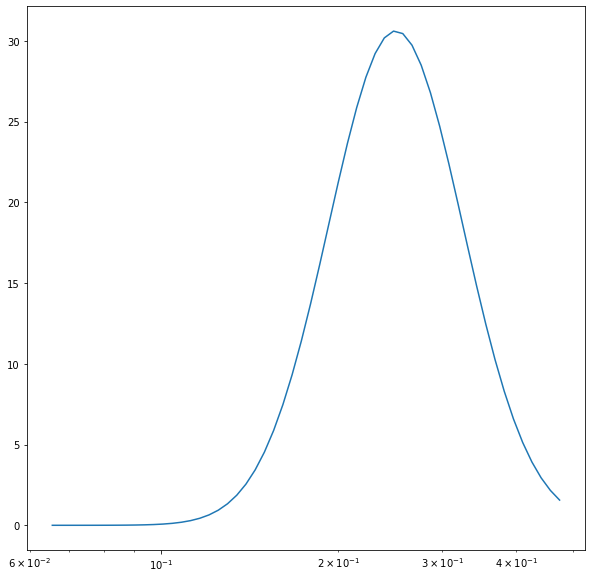

In [112]:
pdf1 = pdf(Vtot1,x_new,mu1,sigma1)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x_new,pdf1)
ax.set_xscale('log')

In [113]:
x_new =np.array([ 0.0655,0.0679,0.07035,0.07295,0.0756,0.07840000000000000,0.08125,0.08425,0.08735,0.09055000000000000,0.09385000000000000,0.0973,0.10085,0.10455,0.10835000000000000,0.11235000000000000,0.11645,0.1207,0.12515,0.12975,0.1345,0.1394,0.1445,0.14980000000000000,0.15530000000000000,0.161,0.1669,0.173,0.179350,0.1859,0.19270,0.19975,0.2071,0.2147,0.22255,0.2307,0.23915,0.2479,0.257,0.26640000000000000,0.27615000000000000,0.28625,0.29675,0.30765,0.31890000000000000,0.3306,0.3427,0.35525,0.36825,0.38175,0.39575,0.41025,0.42525,0.44085,0.457,0.47375])

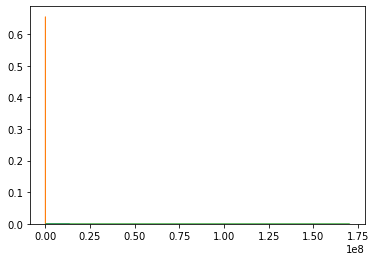

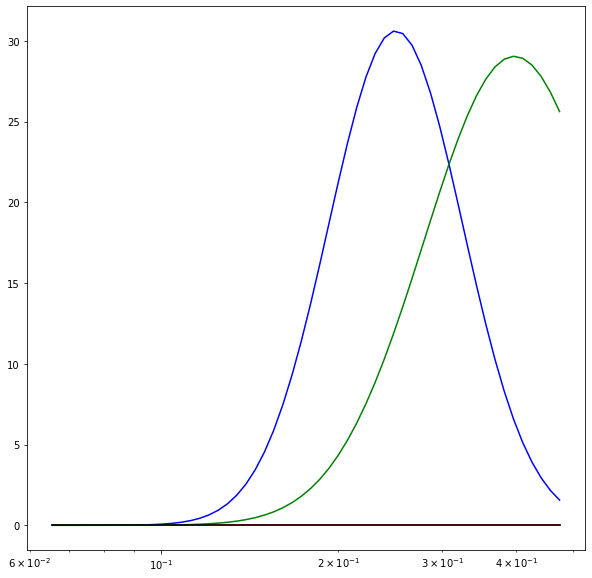

In [114]:

mu2 = dvar_pred_iv5['R_median'][0]
sigma2 = dvar_pred_iv5['GSD'][0]
Vtot2 = dvar_pred_iv5['V_tot'][0]
s2 = np.random.lognormal(mu2, sigma2, 10000)   
count2, bins2, ignored2 = plt.hist(s2, 10000, density=True, align='mid',histtype = 'step')
x2 = np.linspace(min(bins2), max(bins2), 100000)
#pdf2 = Vtot2*(np.exp(-(np.log(x2) - np.log(mu2))**2 / (2 * sigma2**2)) / (sigma2 * np.sqrt(2 * np.pi)))
pdf2 = pdf(Vtot2,x_new,mu2,sigma2)

mu3 = dvar_pred_iv13['R_median'][0]
sigma3 = dvar_pred_iv13['GSD'][0]
Vtot3 = dvar_pred_iv13['V_tot'][0]
s3 = np.random.lognormal(mu3, sigma3, 10000)   
count3, bins3, ignored3 = plt.hist(s3, 10000, density=True, align='mid',histtype = 'step')
x3 = np.linspace(min(bins3), max(bins3), 100000)
#pdf3 = Vtot3*(np.exp(-(np.log(x3) - np.log(mu3))**2 / (2 * sigma3**2)) / (sigma3 * np.sqrt(2 * np.pi)))
pdf3 = pdf(Vtot3,x_new,mu3,sigma3)


mu4 = dvar_pred_iv19['R_median'][0]
sigma4 = dvar_pred_iv19['GSD'][0]
Vtot4 = dvar_pred_iv19['V_tot'][0]
s4 = np.random.lognormal(mu4, sigma4, 10000)   
count4, bins4, ignored4 = plt.hist(s4, 10000, density=True, align='mid',histtype = 'step')
x4 = np.linspace(min(bins4), max(bins4), 100000)
#pdf4 = Vtot4*(np.exp(-(np.log(x4) - np.log(mu1))**2 / (2 * sigma4**2)) / (sigma4 * np.sqrt(2 * np.pi)))
pdf4 = pdf(Vtot4,x_new,mu4,sigma4)




fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x_new,pdf2,'r')
ax.plot(x_new,pdf1,'b')
ax.plot(x_new,pdf3,'g')
ax.plot(x_new,pdf4,'k')
ax.set_xscale('log')

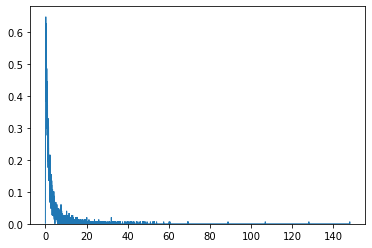

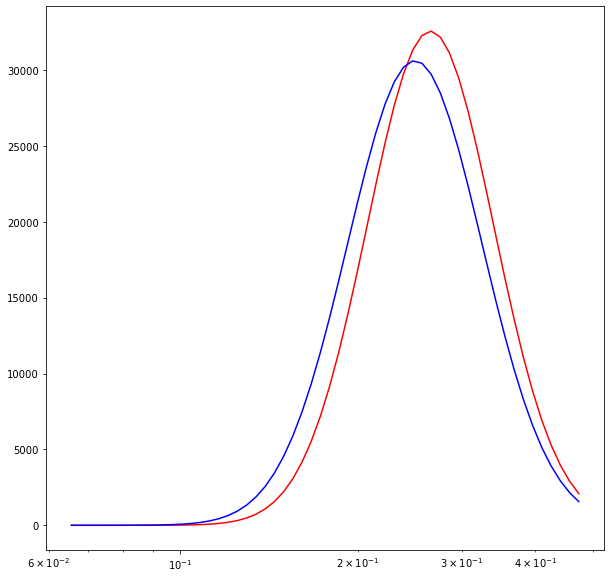

In [115]:
mu1_2 = Parameters2['R_median'][0]
sigma1_2 = Parameters2['GSD'][0]
Vtot1_2 = Parameters2['V_tot'][0]
s1_2 = np.random.lognormal(mu1_2, sigma1_2, 10000)   
count1_2, bins1_2, ignored1_2 = plt.hist(s1_2, 10000, density=True, align='mid',histtype = 'step')
x1_2 = np.linspace(min(bins1_2), max(bins1_2), 100000)
#pdf1_2 = Vtot1_2*(np.exp(-(np.log(x1_2) - np.log(mu1_2))**2 / (2 * sigma1_2**2)) / ( sigma1_2 * np.sqrt(2 * np.pi)))
pdf1_2 = pdf(Vtot1_2,x_new,mu1_2,sigma1_2)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x_new,pdf1_2*1000,'r')
ax.plot(x_new,pdf1*1000,'b')
ax.set_xscale('log')

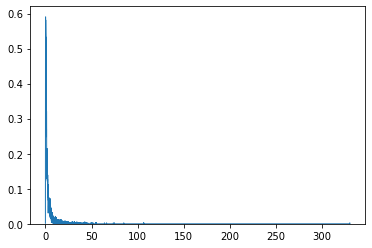

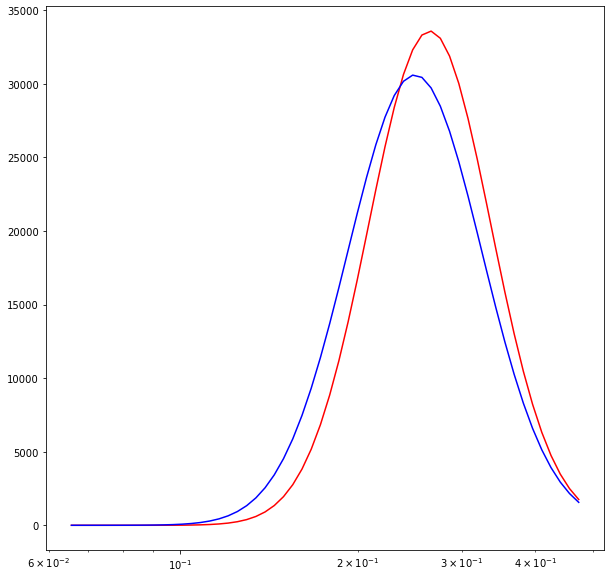

In [116]:
mu1_3 = Parameters3['R_median'][0]
sigma1_3 = Parameters3['GSD'][0]
Vtot1_3 = Parameters3['V_tot'][0]
s1_3 = np.random.lognormal(mu1_3, sigma1_3, 10000)   
count1_3, bins1_3, ignored1_3 = plt.hist(s1_3, 10000, density=True, align='mid',histtype = 'step')
x1_3 = np.linspace(min(bins1_3), max(bins1_3), 100000)
#pdf1_3 = Vtot1_3*(np.exp(-(np.log(x1_3) - np.log(mu1_3))**2 / (2 * sigma1_3**2)) / (sigma1_2 * np.sqrt(2 * np.pi)))
pdf1_3 = pdf(Vtot1_3,x_new,mu1_3,sigma1_3)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x_new,pdf1_3*1000,'r')
ax.plot(x_new,pdf1*1000,'b')
ax.set_xscale('log')

Text(0, 0.5, 'dV/dlog(r)')

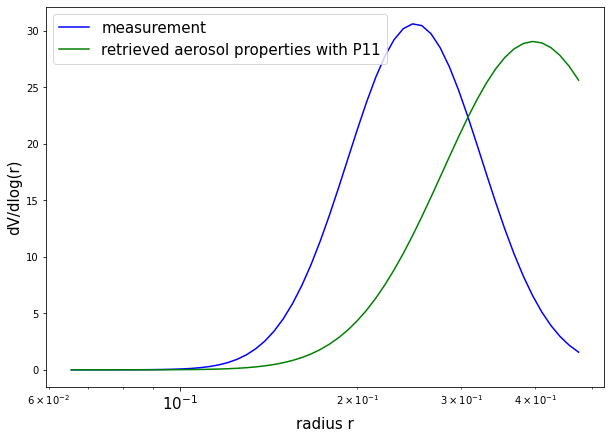

In [117]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(x_new,pdf1,'b',label='measurement')
ax.plot(x_new,pdf3,'g',label='retrieved aerosol properties with P11')

ax.set_xscale('log')
plt.legend(fontsize=15 )
plt.xticks(fontsize =15)
plt.xlabel('radius r',fontsize=15)
plt.ylabel('dV/dlog(r)',fontsize=15)

Text(0, 0.5, 'dV/dlog(r)')

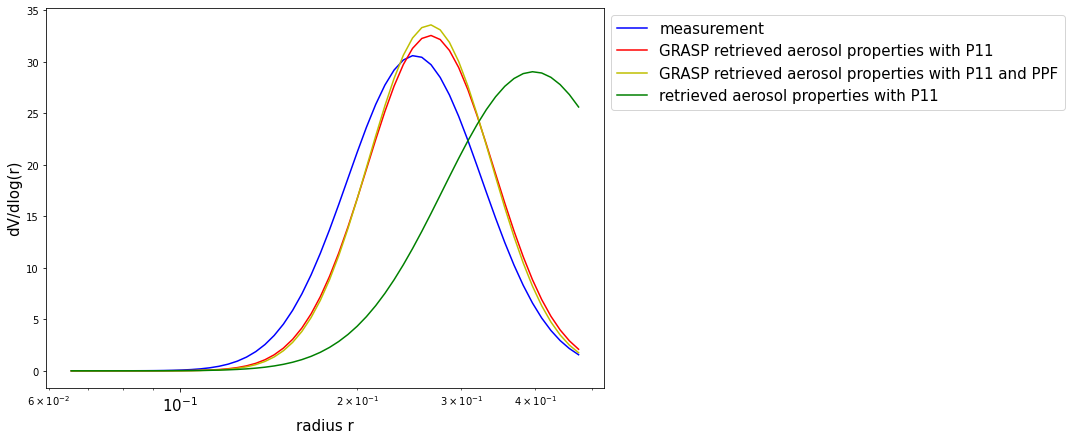

In [118]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(x_new,pdf1,'b',label='measurement')
ax.plot(x_new,pdf1_2,'r',label='GRASP retrieved aerosol properties with P11')
ax.plot(x_new,pdf1_3,'y',label='GRASP retrieved aerosol properties with P11 and PPF')

ax.plot(x_new,pdf3,'g',label='retrieved aerosol properties with P11')

ax.set_xscale('log')
plt.legend(fontsize=15 , bbox_to_anchor=(1,1))
plt.xticks(fontsize =15)
plt.xlabel('radius r',fontsize=15)
plt.ylabel('dV/dlog(r)',fontsize=15)

# Recompute phase functions

In [119]:
qoi_pred_iv_meas5_P1 = surr5.predict(Parameters1)
qoi_pred_iv_meas5_P1 =pd.DataFrame(qoi_pred_iv_meas5_P1,columns= qoi_test5.columns)


qoi_pred_iv_meas5 = surr5.predict(dvar_pred_iv5)
qoi_pred_iv_meas5 =pd.DataFrame(qoi_pred_iv_meas5,columns= qoi_test5.columns)

qoi_pred_iv_meas13 = surr13.predict(dvar_pred_iv13)
qoi_pred_iv_meas13 =pd.DataFrame(qoi_pred_iv_meas13,columns= qoi_test13.columns)

qoi_pred_iv_meas19 = surr19.predict(dvar_pred_iv19)
qoi_pred_iv_meas19 =pd.DataFrame(qoi_pred_iv_meas19,columns= qoi_test19.columns)


In [ ]:
qoi_pred_iv_meas5_P2 = surr5.predict(Parameters2)
qoi_pred_iv_meas5_P2 =pd.DataFrame(qoi_pred_iv_meas5_P2,columns= qoi_test5.columns)

qoi_pred_iv_meas5_P3 = surr5.predict(Parameters3)
qoi_pred_iv_meas5_P3 =pd.DataFrame(qoi_pred_iv_meas5_P3,columns= qoi_test5.columns)




In [ ]:
qoi_pred_iv_meas5_P1

In [ ]:
angles_plot0 = np.arange(5,85)
angles_plot1 = np.arange(96,176)
angles_plot = np.concatenate([angles_plot0 ,angles_plot1])
angles_plot

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'k',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P11")


plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b',label= "measurement data")

plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P11")


plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'k',label= "measurement data")

plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)





In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r.', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g.', label ="predicted from retrieved aerosol properties with P11")




plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c.',label= "predicted from GRASP retrieved aerosol properties binned")
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y.',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b.',label= "measurement data")

plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
Parameters3

In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r.', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P2[P11_column_names].iloc[0],'k.', label="predicted from GRASP 1 aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P3[P11_column_names].iloc[0],'k*', label="predicted from GRASP 2 aerosol properties with P11 and PPF")


plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g.', label ="predicted from retrieved aerosol properties with P11")

plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c.',label= "predicted from GRASP retrieved aerosol properties binned")
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y.',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b.',label= "measurement data")

plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P2[P11_column_names].iloc[0],'k', label="predicted from GRASP 1 aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P3[P11_column_names].iloc[0],'k', label="predicted from GRASP 2 aerosol properties with P11 and PPF")


plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P11")

plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b',label= "measurement data")

plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(angles_plot,qoi_pred_iv_meas5[P12_column_names].iloc[0],'k.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P12_column_names].iloc[0],'r.', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas19[P12_column_names].iloc[0],'g.', label ="predicted from retrieved aerosol properties with P11")


plt.plot(angles_plot,newdata400_c[P12_column_names].iloc[0],'b.',label= "measurement data")


plt.plot(phase_fun400_log['angle'],(phase_fun400_log['PPF']),'y.',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],(phase_fun400_bin['PPF']),'c.',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend(fontsize=10)
plt.ylabel("PPF",fontsize=15)
plt.xlabel("angles",fontsize=15)




plt.xticks(fontsize =15)
plt.yticks(fontsize =15)



In [ ]:
plt.figure(figsize =(10,5))
plt.plot(angles_plot,qoi_pred_iv_meas5[P12_column_names].iloc[0],'k',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P12_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas19[P12_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P12")


plt.plot(angles_plot,newdata400_c[P12_column_names].iloc[0],'b',label= "measurement data")



plt.plot(phase_fun400_log['angle'],(phase_fun400_log['PPF']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],(phase_fun400_bin['PPF']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend()
plt.ylabel("PPF")
plt.xlabel("angles")

In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P12_column_names].iloc[0],'b',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P12_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
#plt.plot(angles_plot,qoi_pred_iv_meas19[P12_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P12")


plt.plot(angles_plot,newdata400_c[P12_column_names].iloc[0],'k',label= "measurement data")



plt.plot(phase_fun400_log['angle'],(phase_fun400_log['PPF']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],(phase_fun400_bin['PPF']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend(fontsize=10)
plt.ylabel("PPF",fontsize=15)
plt.xlabel("angles",fontsize=15)




plt.xticks(fontsize =15)
plt.yticks(fontsize =15)


In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r.', label="predicted from known aerosol properties with P11 and PPF")
#plt.plot(angles_plot,qoi_pred_iv_meas5_P2[P11_column_names].iloc[0],'k', label="predicted from GRASP 1 aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P3[P11_column_names].iloc[0],'k.', label="predicted from retrieved aerosol properties with P11 and replacing n with n=1.45")


plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g.', label ="predicted from retrieved aerosol properties with P11")

plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c.',label= "predicted from GRASP retrieved aerosol properties binned")
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y.',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b.',label= "measurement data")

plt.legend(fontsize=12,bbox_to_anchor = (1,1))
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
qoi_pred_iv_meas5_P2.columns